# SSVQE for BODIPY

MAY 2025
> **Molecule**: 4,4‑difluoro‑4‑bora‑3a,4a‑diaza‑s‑indacene (BODIPY)


### Calcul des énergies de la molecule de BODIPY

In [2]:
# importation des packages
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import pyscf

In [3]:
# coordonnées xyz de la molecule
symbols, coordinates = qchem.read_structure('Bodipy.xyz')
molecule = qml.qchem.Molecule(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis_name='sto-3g')
                              

In [13]:
# Hamiltonien moleculaire
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    molecule,
    mapping='jordan_wigner',
    active_electrons=4,
    active_orbitals=4,
    method="pyscf"
)
print(f'Hamiltonian built with {qubits} qubits')
print(hamiltonian)

Hamiltonian built with 8 qubits
-589.0840495180895 * I([0, 1, 2, 3, 4, 5, 6, 7]) + 0.14008146405752264 * Z(0) + 0.0030267712471427244 * (Y(0) @ Z(1) @ Y(2)) + 0.0030267712471427244 * (X(0) @ Z(1) @ X(2)) + 0.007086501999187079 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 0.007086501999187079 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + -0.0034844009364043485 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.0034844009364043485 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.08071466204310572 * Z(2) + 0.0494315755969744 * (Z(0) @ Z(2)) + 0.0016451797379319743 * (Y(2) @ Z(3) @ Y(4)) + 0.0016451797379319743 * (X(2) @ Z(3) @ X(4)) + 0.000676862433369899 * (Z(0) @ Y(2) @ Z(3) @ Y(4)) + 0.000676862433369899 * (Z(0) @ X(2) @ Z(3) @ X(4)) + -0.03820229673453774 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.03820229673453774 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.015257827587719146 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.015257827587719146 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 

In [53]:
# definir l'Ansatz UCCSD
#Circuit Anstaz:
def ansatz(params, wires, s_wires, d_wires, hf_state):
    qml.UCCSD(params, wires, s_wires, d_wires, hf_state)
    #return qml.expval(hamiltonian)

In [54]:
# Params:
params = np.random.uniform(0, 2*np.pi, (8, qubits, 3))


# Define the initial values of the circuit parameters
#params = np.zeros(len(singles) + len(doubles))

In [44]:
# definir l'Ansatz
#Circuit Anstaz:
#def ansatz(params, wires):
    #qml.templates.StronglyEntanglingLayers(params, wires=wires)

In [60]:
def WEIGHTED_SSVQE(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=250, k=0, device_name='default.qubit'):
    """Calculates the kth excited state energy for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K for which the Kth excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).
    Returns:
        => (Energy, Energies): The function returns a tuple of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)
    
    electrons = 4 #active_electrons (même nombre que plus haut)

    # Define the HF state
    hf_state = qml.qchem.hf_state(electrons, qubits)
    
    # Generate single and double excitations
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    # Define the initial values of the circuit parameters
    params = np.zeros(len(singles) + len(doubles))

    #Define the weights for the cost function.
    weights = np.random.random()

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)
    
    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires, s_wires, d_wires, hf_state)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(k+1):
        if index == k:
          cost += weights * state_cost(params, state_value=index)
        else:
          cost += state_cost(params, state_value=index)
            
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = []
    
    # Optimization loop.
    for _ in range(iterations):
      params = optimizer.step(total_cost, params)
      energy = state_cost(params, state_value=k)
      energies.append(energy)
    return energies[-1], energies

In [63]:
def WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=250, k=[0], device_name='default.qubit'):
    """Calculates the energies upto Kth excited state for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K till which the excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => [[Energy, Energies]]: The function returns a List of List of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)
    
    electrons = 4 #active_electrons (même nombre que plus haut)

    # Define the HF state
    hf_state = qml.qchem.hf_state(electrons, qubits)
    
    # Generate single and double excitations
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    # Define the initial values of the circuit parameters
    params = np.zeros(len(singles) + len(doubles))

    #Define the weights for the cost function.
    weights = np.arange(k+1, 0, -1)

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)

    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires, s_wires, d_wires, hf_state)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(k+1):
          cost += weights[index] * state_cost(params, state_value=index)
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = np.zeros((k+1,iterations))
    
    # Optimization loop.
    for itr in range(iterations):
      params = optimizer.step(total_cost, params)
      for index in range(k+1):
        energy = state_cost(params, state_value=index)
        energies[index][itr] = energy

    # Return List
    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies

In [64]:
def WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=250, k=[0], device_name='default.qubit'):
    """Calculates the kth excited state energy from the list of values of k for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (List(int)): List of K for which the Kth excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => [[Energy, Energies]]: The function returns a List of list of Energy of Kth excited state and list of energies at each iteration for plotting the graph. 
           The list will be in the sorted order of elements in the list k.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)
    
    electrons = 4 #active_electrons (même nombre que plus haut)

    # Define the HF state
    hf_state = qml.qchem.hf_state(electrons, qubits)
    
    # Generate single and double excitations
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    # Define the initial values of the circuit parameters
    params = np.zeros(len(singles) + len(doubles))

    #Define the weights for the cost function.
    weights = np.arange(max(k)+1,0,-1)

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)

    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires, s_wires, d_wires, hf_state)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(max(k)+1):
          cost += weights[index] * state_cost(params, state_value=index)
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = np.zeros((max(k)+1,iterations))
    
    # Optimization loop.
    for itr in range(iterations):
      params = optimizer.step(total_cost, params)
      for index in range(max(k)+1):
        if index in k:
          energy = state_cost(params, state_value=index)
          energies[index][itr] = energy

    # Return List
    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies

In [61]:
# energies
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, stepsize=0.01, k=0)

In [62]:
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, stepsize=0.01, k=1)

In [65]:
# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, stepsize=0.01, k=1)

In [66]:
# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, stepsize=0.01, k=[0,1,2,3])

In [70]:
# Output:
print('Weighted SSVQE:')
print('Energy of Ground state for the Bodipy hamiltonian is:', energy_G_1)
print('Energy of First Excited state for the Bodipy hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of Ground state for the Bodipy hamiltonian is:', energies_all[0][0])
print('Energy of First Excited state for the Bodipy hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of Ground state for the Bodipy hamiltonian is:', energies_custom[0][0])
print('Energy of First Excited state for the Bodipy hamiltonian is:', energies_custom[1][0])
print('Energy of Second Excited state for the Bodipy hamiltonian is:', energies_custom[2][0])
print('Energy of Third Excited state for the Bodipy hamiltonian is:', energies_custom[3][0])


Weighted SSVQE:
Energy of Ground state for the Bodipy hamiltonian is: -589.7035274140981
Energy of First Excited state for the Bodipy hamiltonian is: -589.5833272576905

Weighted SSVQE All:
Energy of Ground state for the Bodipy hamiltonian is: -589.7027349196992
Energy of First Excited state for the Bodipy hamiltonian is: -589.5866715512072

Weighted SSVQE Custom:
Energy of Ground state for the Bodipy hamiltonian is: -589.7019608981441
Energy of First Excited state for the Bodipy hamiltonian is: -589.5855396215135
Energy of Second Excited state for the Bodipy hamiltonian is: -589.5834301031463
Energy of Third Excited state for the Bodipy hamiltonian is: -589.2133055427989


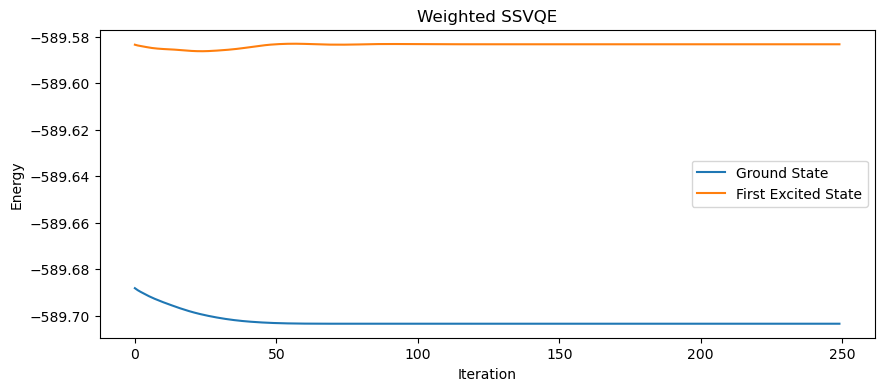

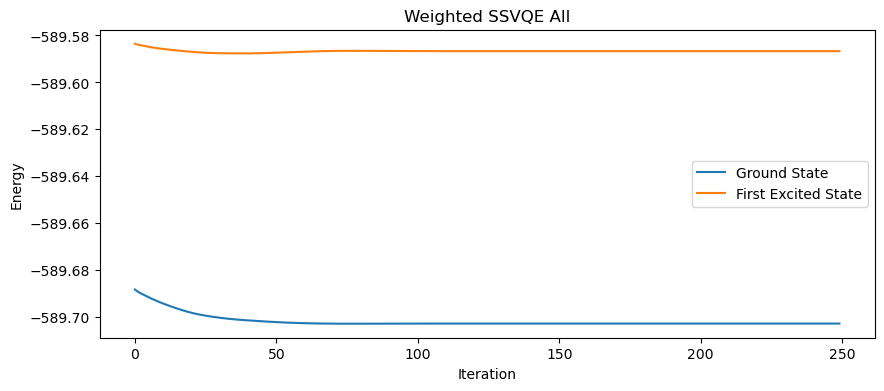

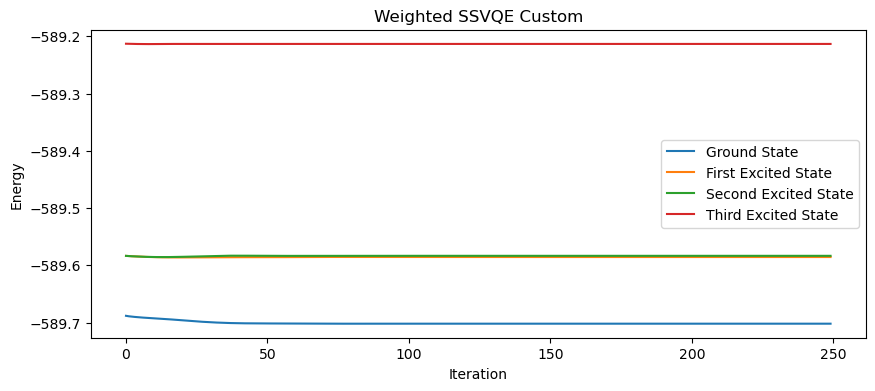

In [71]:
# Graph plot:
Iterations = [*range(0, 250)]
#Iterations2 = [*range(0, 200)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='Ground State')
plt.plot(Iterations, energies_1_1, label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='Ground State')
plt.plot(Iterations, energies_all[1][1], label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations, energies_custom[0][1], label='Ground State')
plt.plot(Iterations, energies_custom[1][1], label='First Excited State')
plt.plot(Iterations, energies_custom[2][1], label='Second Excited State')
plt.plot(Iterations, energies_custom[3][1], label='Third Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

Avec l'UCCSD je pense qu'on peut s'arrêter à 100 itérations

In [76]:
energies_all[1][1][99]

tensor(-589.5866807, requires_grad=True)

In [77]:
energies_all[1][1][100]

tensor(-589.58668184, requires_grad=True)

In [78]:
energies_all[1][1][101]

tensor(-589.58668239, requires_grad=True)

In [83]:
energies_all[1][1][-1]

tensor(-589.58667155, requires_grad=True)

In [79]:
energies_custom[1][1][99]

tensor(-589.58553042, requires_grad=True)

In [80]:
energies_custom[1][1][100]

tensor(-589.58553222, requires_grad=True)

In [81]:
energies_custom[1][1][101]

tensor(-589.58553409, requires_grad=True)

In [82]:
energies_custom[1][1][-1]

tensor(-589.58553962, requires_grad=True)

In [85]:
#Energies d'excitation
E_S0 = energies_custom[0][0]
E_S1 = energies_custom[1][0]
E_S2 = energies_custom[2][0]

exc_S1 = (E_S1 - E_S0) * 27.2114
exc_S2 = (E_S2 - E_S0) * 27.2114

print(f"Énergie fondamentale S0 : {E_S0:.6f} Ha")
print(f"Énergie excitée S1 : {E_S1:.6f} Ha → ΔE = {exc_S1:.2f} eV")
print(f"Énergie excitée S2 : {E_S2:.6f} Ha → ΔE = {exc_S2:.2f} eV")

Énergie fondamentale S0 : -589.701961 Ha
Énergie excitée S1 : -589.585540 Ha → ΔE = 3.17 eV
Énergie excitée S2 : -589.583430 Ha → ΔE = 3.23 eV
